In [4]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.collocations import *
from nltk.tokenize import *
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.pyplot as plt
%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
!git clone https://github.com/lyaronskaya/ml-stuff.git

Cloning into 'ml-stuff'...
remote: Counting objects: 2569, done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2569 (delta 0), reused 0 (delta 0), pack-reused 2566
Receiving objects: 100% (2569/2569), 798.69 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking connectivity... done.
Checking out files: 100% (2533/2533), done.


### a, b

In [8]:
# aliases = pd.read_csv('Aliases.csv')
# email_receivers = pd.read_csv('EmailReceivers.csv')
emails = pd.read_csv('ml-stuff/Emails.csv')
# persons = pd.read_csv('Persons.csv')

In [4]:
aliases.head()

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2
2,3,ap,3
3,4,asuncion,4
4,5,alec,5


In [5]:
email_receivers.head()

,Id,EmailId,PersonId
0,1,1,80
1,2,2,80
2,3,3,228
3,4,3,80
4,5,4,80


In [6]:
emails.head(3)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...


In [9]:
print(emails.RawText[1])

UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739546
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Attachments:
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
CONFIDENTIAL
March 3, 2011
For: Hillary
From: Sid
Re: Syria aiding Qaddafi
This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note
to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly complex crisis. It
seems that the situation is developing into a protracted civil war with various nations backing opposing sides
with unforeseen consequences. Under these circumstances the crucial challenge is to deprive Qaddafi of his
strategic depth—his support bo

### c. 

Предобработка: приводим к нижнему регистру слова(чтобы уменьшить количество слов), убираем метаданные письма.

In [14]:
emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

In [9]:
metadata_prefixes = ('unclassified', 'case no', 'doc no', 'date', 'state', 'subject to agreement', 'release in', \
                    'part', 'from', 'sent', 'to', 'subject:', 'attachments', 'u.s. department of state', \
                     'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', \
                    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'semptember', \
                    'october', 'november', 'december', \
                    'for:', 'from:', 're:', '\\x0')

In [10]:
emails['Cleaned_text'] = emails['RawText'].apply(lambda raw_text: 
                " ".join(list(filter(lambda s: not s.startswith(metadata_prefixes), raw_text.lower().split('\n')))))

In [11]:
emails.Cleaned_text[1]

"b6 h: latest how syria is aiding qaddafi and more... sid hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx confidential this memo has two parts. part one is the report that syria is providing air support for qaddafi. part two is a note seems that the situation is developing into a protracted civil war with various nations backing opposing sides with unforeseen consequences. under these circumstances the crucial challenge is to deprive qaddafi of his strategic depth\xe2\x80\x94his support both financial and military. i. report during the afternoon of march 3, advisers to muammar qaddafi stated privately that the libyan leader has decided that civil war is inevitable, pitting troops and mercenary troops loyal to him against the rebel forces gathering around benghazi. qaddafi is convinced that these rebels are being supported by the united states, western europe and israel. on march 2 qaddafi told his son saif al-islam that he believes the intelligence serv

### d.

In [56]:
vectorizer = CountVectorizer(ngram_range=(2,2))
document_bigrams_matrix = vectorizer.fit_transform(emails.Cleaned_text)

In [54]:
most_frequent_idx = np.argmax(bigram_document_matrix.sum(axis=0), axis=1)

In [60]:
{i: b for b, i in vectorizer.vocabulary_.items()}[most_frequent_idx[0, 0]]

'of the'

### e.

In [80]:
finder = BigramCollocationFinder.from_words(wordpunct_tokenize("\t\n".join(emails.Cleaned_text)), window_size=10)

In [77]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(3)
finder.nbest(bigram_measures.pmi, 10)

[('-mukhabarat', 'el-khabeya'),
 ('15/10/10', '18:22'),
 ('1865', '281447'),
 ('2.ahmad', 'bukatela'),
 ('2ccm-', '86804491_1261527777'),
 ('3.muhammad', 'al-zahawi'),
 ('432', '1660'),
 ('451', '4.4.1'),
 ('abhisit', 'vejjajiva'),
 ('abuzaid', 'dorda')]

Вместе встречаются имя и фамилия.

### f.

In [100]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english', min_df=0.1)
corpora = vectorizer.fit_transform(emails.Cleaned_text)

In [101]:
tsne = TSNE()
X_tsne = tsne.fit_transform(corpora.todense())

In [111]:
n_clusters = 3

In [112]:
kmeans_model = KMeans(n_clusters)
y = kmeans_model.fit_predict(corpora)

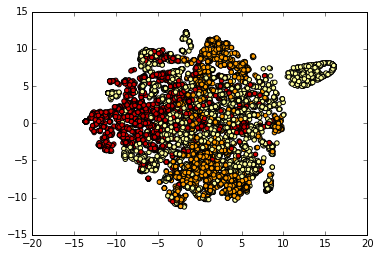

In [113]:
color_dict = plt.cm.hot(np.linspace(0.3, 0.9, n_clusters))
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=color_dict[y])
plt.show()

### g.

In [114]:
idx_to_word = {i: w for w, i in vectorizer.vocabulary_.iteritems()}

In [115]:
def get_top_words(cluster_id, corpora, num_top_words=10):
    words = corpora[np.where(y == cluster_id)]
    center_dist = np.array(words.mean(axis=0))[0]
    top_words_idxs = np.argsort(center_dist)[-num_top_words:]
    top_words = [idx_to_word[idx] for idx in top_words_idxs]
    return top_words

In [122]:
top_words_per_cluster = [get_top_words(c, corpora, 50) for c in range(n_clusters)]

In [123]:
print("\n\n".join(["Cluster {}: \n".format(i) + "\t".join(s) for i, s in enumerate(top_words_per_cluster)]))

Cluster 0: 
think	sullivan	don	going	work	good	abedin	30	need	b5	did	like	cheryl	fyi	time	want	huma	gov	let	today	talk	subject	state	tomorrow	just	know	cc	b6	original	message

Cluster 1: 
work	states	support	world	cc	original	30	united	time	foreign	people	message	clinton	security	secretary	08	new	president	government	31	said	2014	20439	doc	date	2015	unclassified	case	department	state

Cluster 2: 
think	thanks	message	talk	new	want	work	like	need	time	president	know	tomorrow	meeting	b5	today	fyi	sullivan	office	cheryl	just	secretary	abedin	said	gov	huma	state	subject	b6	cc


It doesn't seem to be good.:(

Найдем уникальные для каждого кластера:

In [136]:
from itertools import chain

def list_to_set(l):
    return set(list(chain.from_iterable(l)))
 
unique_top_words = [list(set(top_words) - list_to_set(top_words_per_cluster[:i] + top_words_per_cluster[i+1:])) 
                    for i, top_words in enumerate(top_words_per_cluster)]

In [137]:
print("\n\n".join(["Cluster {}: \n".format(i) + "\t".join(s) for i, s in enumerate(unique_top_words)]))

Cluster 0: 
did	don	good	going	let

Cluster 1: 
case	unclassified	united	clinton	08	people	doc	support	government	foreign	states	department	31	2014	2015	world	security	date	20439

Cluster 2: 
meeting	thanks	office
